Setup complete!
Sampling mode: ON - Using a subset of data for testing
Processing max 2 chunks with up to 1000 sessions per chunk
Loading buys data...
Setting up columns for clicks data...
Buys data shape: (1150753, 5)
   session                 timestamp    item_id  price  qty
0   420374  2014-04-06T18:44:58.314Z  214537888  12462    1
1   420374  2014-04-06T18:44:58.325Z  214537850  10471    1
2   281626  2014-04-06T09:40:13.032Z  214535653   1883    1
3   420368  2014-04-04T06:13:28.848Z  214530572   6073    1
4   420368  2014-04-04T06:13:28.858Z  214835025   2617    1
Exploring buys data...


Transforming buys data...
Buys transformation complete
         Number_items_bought                unique_items_bought  is_buy
session                                                                
11                         2                        [214821371]       1
12                         1                        [214717867]       1
21                         2             [214548744, 214838503]       1
33                         6  [214834865, 214706441, 214820225]       1
46                         2                        [214716932]       1
Processing clicks data in chunks (session timing analysis)...
Processing chunk 1 for timing analysis...
Processing chunk 2 for timing analysis...
Stopping after 2 chunks (sample mode)
Completed timing analysis of clicks data
Processing clicks data in chunks (item analysis)...
Processing chunk 1 for item analysis...
Processing chunk 2 for item analysis...
Stopping after 2 chunks (sample mode)
Completed item analysis of clicks data
Process

Average dwell time for buying sessions: 750.38 seconds
Average dwell time for non-buying sessions: 359.64 seconds


Class distribution (Buy vs. Not Buy):
is_buy
0.0    7378
1.0     520
Name: count, dtype: int64
Buy ratio: 0.0658
Handling class imbalance...
Class distribution after balancing:
is_buy
1.0    520
0.0    520
Name: count, dtype: int64
Performing feature engineering...


Preparing data for modeling...
Training set: 832 samples
Test set: 208 samples
Training Logistic Regression model...

Logistic Regression Results:
Accuracy: 0.5192
AUC: 0.5486

Confusion Matrix:
                Predicted Not Buy  Predicted Buy
Actual Not Buy                 41             66
Actual Buy                     34             67

Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.38      0.45       107
         1.0       0.50      0.66      0.57       101

    accuracy                           0.52       208
   macro avg       0.53      0.52      0.51       208
weighted avg       0.53      0.52      0.51       208



/home/rjn/miniconda3/envs/cuda/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



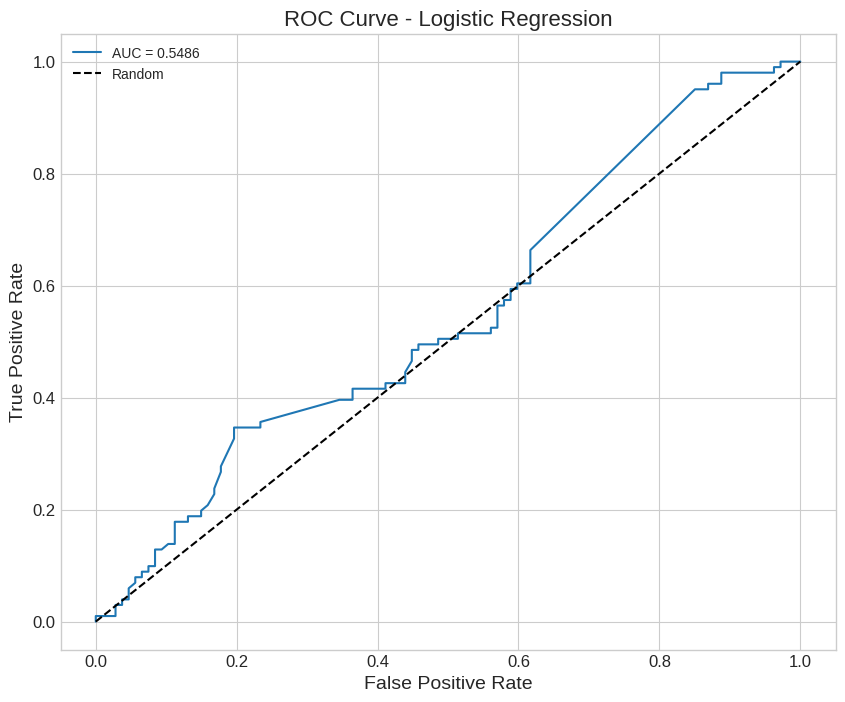

Optimal threshold: 0.5103


In [2]:
# E-Commerce Clickstream Data Analytics

## Setup and Imports

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import datetime
import warnings
from decimal import Decimal

import matplotlib.pyplot as plt
import numpy as np

# Import necessary libraries
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    mean_squared_error,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

warnings.filterwarnings("ignore", category=FutureWarning)

# More modern imports for machine learning models
import lightgbm as lgb

# Deep learning imports (using PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Define file paths
clicks_file = "data/yoochoose-data/yoochoose-clicks.dat"
buys_file = "data/yoochoose-data/yoochoose-buys.dat"

# Setting up better visualization defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

# Sampling configuration - Option 1
SAMPLE_MODE = True  # Set to False to process the full dataset
MAX_CHUNKS = 2  # Process only first 2 chunks instead of all 67
SAMPLE_SESSIONS = 1000  # Limit to this many sessions

print("Setup complete!")
print(
    f"Sampling mode: {'ON - Using a subset of data for testing' if SAMPLE_MODE else 'OFF - Using full dataset'}"
)

if SAMPLE_MODE:
    print(
        f"Processing max {MAX_CHUNKS} chunks with up to {SAMPLE_SESSIONS} sessions per chunk"
    )

## Helper Functions


def convert_category(x):
    """
    Handle Category column in the clicks data (Numerical Encoding 1-12 for Category of Items)
    """
    if x == "S":
        return -1
    elif x in ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]:
        return x
    else:
        return 13


def check_item_in_purchases(first_item, last_item, unique_items_bought, is_buy):
    """
    Check if first or last clicked item is in the set of purchased items
    """
    if is_buy == 1:
        if first_item in unique_items_bought or last_item in unique_items_bought:
            return True
    return False


def get_preds(threshold, probabilities):
    """
    Convert probabilities to binary predictions based on threshold
    """
    return [1 if prob > threshold else 0 for prob in probabilities]


def calc_special_offer_click(categories):
    """
    Determine if a session included a special offer click
    """
    if -1 in categories:
        return 1
    else:
        return 0


def p_root(value, root):
    """
    Calculate p-root of a value
    """
    root_value = 1 / float(root)
    return round(Decimal(value) ** Decimal(root_value), 3)


def minkowski_distance(x, y, p_value):
    """
    Calculate Minkowski distance between two vectors
    """
    return p_root(sum(pow(abs(a - b), p_value) for a, b in zip(x, y)), p_value)


## Data Loading

print("Loading buys data...")
# Load buys data
buys = pd.read_csv(buys_file, names=["session", "timestamp", "item_id", "price", "qty"])

# Data Loading for Clicks (processing in chunks will be done later)
print("Setting up columns for clicks data...")
clicks_columns = ["session", "timestamp", "item_id", "category"]

# Display initial output to confirm data loading
print(f"Buys data shape: {buys.shape}")
print(buys.head())

## Data Exploration - Buys

print("Exploring buys data...")

top_bought_items = buys["item_id"].value_counts().nlargest(10)
fig = px.bar(
    x=top_bought_items.index.astype(str),
    y=top_bought_items.values,
    title="Top 10 Items with Maximum Purchases",
    labels={"x": "Item ID", "y": "Count"}
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

# Top 10 items which are purchased in larger quantities
quantity_analysis = (
    buys.groupby("item_id")["qty"].sum().sort_values(ascending=False).nlargest(10)
)
fig = px.bar(
    x=quantity_analysis.index.astype(str),
    y=quantity_analysis.values,
    title="Top 10 Items Purchased in Larger Quantities",
    labels={"x": "Item ID", "y": "Total Quantity"}
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()


# Top 10 items with maximum price
price_analysis = (
    buys[["item_id", "price"]]
    .drop_duplicates()
    .sort_values("price", ascending=False)
    .nlargest(10, "price")
)
fig = px.bar(
    x=price_analysis["item_id"].astype(str),
    y=price_analysis["price"],
    title="Top 10 Items with Highest Prices",
    labels={"x": "Item ID", "y": "Price"}
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

## Transforming Buys Data

print("Transforming buys data...")
# Group buys by session
grouped_buys = buys.groupby("session")
buys_transformed = pd.DataFrame(index=grouped_buys.groups.keys())

# Calculate metrics for each buying session
buys_transformed["Number_items_bought"] = grouped_buys.item_id.count()
buys_transformed["unique_items_bought"] = grouped_buys.item_id.apply(
    lambda x: list(x.unique())
)
buys_transformed["is_buy"] = 1
buys_transformed.index.name = "session"

print("Buys transformation complete")
print(buys_transformed.head())

## Loading and Transforming Clicks Data (in chunks)

# Step 1: Process clicks for session timing analysis
print("Processing clicks data in chunks (session timing analysis)...")
result_timing = None
count = 1

for chunk in pd.read_csv(
    clicks_file,
    names=clicks_columns,
    usecols=["session", "timestamp", "item_id", "category"],
    parse_dates=["timestamp"],
    chunksize=500000,
):
    print(f"Processing chunk {count} for timing analysis...")

    # SAMPLING: If in sample mode, take only a subset of sessions
    if SAMPLE_MODE:
        unique_sessions = chunk["session"].unique()
        if len(unique_sessions) > SAMPLE_SESSIONS:
            sample_sessions = np.random.choice(
                unique_sessions, SAMPLE_SESSIONS, replace=False
            )
            chunk = chunk[chunk["session"].isin(sample_sessions)]

    # Group by session to analyze timing
    chunk_grouped = chunk.groupby("session")
    chunk_timing = pd.DataFrame()

    # Calculate session timing metrics
    chunk_timing["min"] = chunk_grouped["timestamp"].min()
    chunk_timing["max"] = chunk_grouped["timestamp"].max()
    chunk_timing["dwell_time"] = chunk_timing["max"] - chunk_timing["min"]
    chunk_timing["dwell_time_seconds"] = chunk_timing["dwell_time"].dt.total_seconds()
    chunk_timing["total_clicks"] = chunk_grouped.size()
    chunk_timing["dayofweek"] = chunk_timing["min"].dt.dayofweek
    chunk_timing["dayofmonth"] = chunk_timing["min"].dt.day
    chunk_timing["hourofclick"] = chunk_timing["min"].dt.hour

    # Create time of day categories
    time_bins = [0, 4, 8, 12, 16, 20, 24]
    time_labels = ["Late Night", "Early Morning", "Morning", "Noon", "Evening", "Night"]
    chunk_timing["timeofday"] = pd.cut(
        chunk_timing["hourofclick"],
        bins=time_bins,
        labels=time_labels,
        include_lowest=True,
    )

    # Calculate click rate (clicks per second)
    chunk_timing["click_rate"] = (
        chunk_timing["total_clicks"] / chunk_timing["dwell_time_seconds"]
    )
    chunk_timing["click_rate"] = chunk_timing["click_rate"].replace(np.inf, np.nan)
    chunk_timing["click_rate"] = chunk_timing["click_rate"].fillna(0)

    # Combine results
    if result_timing is None:
        result_timing = chunk_timing
    else:
        result_timing = pd.concat([result_timing, chunk_timing])

    count += 1

    # SAMPLING: Stop after MAX_CHUNKS in sample mode
    if SAMPLE_MODE and count > MAX_CHUNKS:
        print(f"Stopping after {MAX_CHUNKS} chunks (sample mode)")
        break

print("Completed timing analysis of clicks data")

# Step 2: Process clicks for item analysis
print("Processing clicks data in chunks (item analysis)...")
result_items = None
count = 1

for chunk in pd.read_csv(
    clicks_file,
    names=clicks_columns,
    usecols=["session", "item_id", "category"],
    chunksize=500000,
):
    print(f"Processing chunk {count} for item analysis...")

    # SAMPLING: If in sample mode, take only a subset of sessions
    if SAMPLE_MODE:
        unique_sessions = chunk["session"].unique()
        if len(unique_sessions) > SAMPLE_SESSIONS:
            sample_sessions = np.random.choice(
                unique_sessions, SAMPLE_SESSIONS, replace=False
            )
            chunk = chunk[chunk["session"].isin(sample_sessions)]

    # Group by session
    chunk_grouped = chunk.groupby("session")

    # Get first/last clicked items and unique counts
    chunk_items = pd.DataFrame()
    chunk_items["first_clicked_item"] = chunk_grouped["item_id"].first()
    chunk_items["last_clicked_item"] = chunk_grouped["item_id"].last()
    chunk_items["total_unique_items"] = chunk_grouped["item_id"].nunique()
    chunk_items["total_unique_categories"] = chunk_grouped["category"].nunique()

    # Combine results
    if result_items is None:
        result_items = chunk_items
    else:
        result_items = pd.concat([result_items, chunk_items])

    count += 1

    # SAMPLING: Stop after MAX_CHUNKS in sample mode
    if SAMPLE_MODE and count > MAX_CHUNKS:
        print(f"Stopping after {MAX_CHUNKS} chunks (sample mode)")
        break

print("Completed item analysis of clicks data")

# Step 3: Process clicks for sequence analysis
print("Processing clicks data in chunks (sequence analysis)...")
visited_items_by_session = {}
count = 1

for chunk in pd.read_csv(
    clicks_file, names=clicks_columns, usecols=["session", "item_id"], chunksize=500000
):
    print(f"Processing chunk {count} for sequence analysis...")

    # SAMPLING: If in sample mode, take only a subset of sessions
    if SAMPLE_MODE:
        unique_sessions = chunk["session"].unique()
        if len(unique_sessions) > SAMPLE_SESSIONS:
            sample_sessions = np.random.choice(
                unique_sessions, SAMPLE_SESSIONS, replace=False
            )
            chunk = chunk[chunk["session"].isin(sample_sessions)]

    # Group items by session
    for session, items in chunk.groupby("session")["item_id"]:
        if session in visited_items_by_session:
            visited_items_by_session[session].extend(items.tolist())
        else:
            visited_items_by_session[session] = items.tolist()

    count += 1

    # SAMPLING: Stop after MAX_CHUNKS in sample mode
    if SAMPLE_MODE and count > MAX_CHUNKS:
        print(f"Stopping after {MAX_CHUNKS} chunks (sample mode)")
        break

# Convert to DataFrame
result_sequences = pd.DataFrame(
    {
        "session": list(visited_items_by_session.keys()),
        "visited_items": list(visited_items_by_session.values()),
    }
).set_index("session")

print("Completed sequence analysis of clicks data")

# Step 4: Process clicks for category analysis
print("Processing clicks data in chunks (category analysis)...")
visited_categories_by_session = {}
count = 1

for chunk in pd.read_csv(
    clicks_file,
    names=clicks_columns,
    usecols=["session", "category"],
    converters={"category": convert_category},
    chunksize=500000,
):
    print(f"Processing chunk {count} for category analysis...")

    # SAMPLING: If in sample mode, take only a subset of sessions
    if SAMPLE_MODE:
        unique_sessions = chunk["session"].unique()
        if len(unique_sessions) > SAMPLE_SESSIONS:
            sample_sessions = np.random.choice(
                unique_sessions, SAMPLE_SESSIONS, replace=False
            )
            chunk = chunk[chunk["session"].isin(sample_sessions)]

    # Group categories by session
    for session, categories in chunk.groupby("session")["category"]:
        if session in visited_categories_by_session:
            visited_categories_by_session[session].extend(categories.tolist())
        else:
            visited_categories_by_session[session] = categories.tolist()

    count += 1

    # SAMPLING: Stop after MAX_CHUNKS in sample mode
    if SAMPLE_MODE and count > MAX_CHUNKS:
        print(f"Stopping after {MAX_CHUNKS} chunks (sample mode)")
        break

# Convert to DataFrame
result_categories = pd.DataFrame(
    {
        "session": list(visited_categories_by_session.keys()),
        "visited_categories": list(visited_categories_by_session.values()),
    }
).set_index("session")

# Add derived metrics
result_categories["Number_clicked_visited_categories"] = result_categories[
    "visited_categories"
].apply(len)
result_categories["Special_offer_click"] = result_categories[
    "visited_categories"
].apply(calc_special_offer_click)

print("Completed category analysis of clicks data")

## Calculate Item Popularity

print("Calculating item popularity from clicks...")
# Clicks popularity
clicks_counts = pd.DataFrame()
count = 1

for chunk in pd.read_csv(
    clicks_file, names=clicks_columns, usecols=["item_id"], chunksize=500000
):
    print(f"Processing chunk {count} for item popularity...")

    # SAMPLING: If in sample mode, we still want to process more chunks for popularity
    # to get a more representative distribution, but we can cap it
    if SAMPLE_MODE and count > MAX_CHUNKS * 2:
        print(
            f"Stopping popularity calculation after {MAX_CHUNKS * 2} chunks (sample mode)"
        )
        break

    item_counts = chunk["item_id"].value_counts()

    if clicks_counts.empty:
        clicks_counts = pd.DataFrame(item_counts)
        clicks_counts.columns = ["count"]
    else:
        # Add counts to existing items or create new items
        tmp_counts = pd.DataFrame(item_counts)
        tmp_counts.columns = ["count"]
        clicks_counts = pd.concat([clicks_counts, tmp_counts]).groupby(level=0).sum()

    count += 1

clicks_counts.index.name = "item_id"
total_clicks = clicks_counts["count"].sum()
clicks_counts["popularity"] = clicks_counts["count"] / total_clicks
clicks_counts["popularity"] = clicks_counts["popularity"].round(5)

print("Calculating item popularity from buys...")
# Buys popularity
buys_counts = buys["item_id"].value_counts().to_frame("count")
buys_counts.index.name = "item_id"
total_buys = buys_counts["count"].sum()
buys_counts["popularity"] = buys_counts["count"] / total_buys
buys_counts["popularity"] = buys_counts["popularity"].round(5)

## Combine All Click Information

print("Combining all click information...")
# Check for duplicate indices
for df, name in zip(
    [result_timing, result_items, result_sequences, result_categories],
    ["result_timing", "result_items", "result_sequences", "result_categories"],
):
    if df.index.duplicated().any():
        print(f"Found duplicate indices in {name}, fixing...")
        # Take the first occurrence of each duplicated index
        df = df[~df.index.duplicated(keep="first")]

# Make sure all dataframes have unique indices before concatenating
result_timing = result_timing[~result_timing.index.duplicated(keep="first")]
result_items = result_items[~result_items.index.duplicated(keep="first")]
result_sequences = result_sequences[~result_sequences.index.duplicated(keep="first")]
result_categories = result_categories[~result_categories.index.duplicated(keep="first")]

# Merge all click analysis DataFrames
clicks_combined = pd.concat(
    [result_timing, result_items, result_sequences, result_categories],
    axis=1,
    join="outer",
)

print("Clicks combined data shape:", clicks_combined.shape)

## Merge with Buy Information and Add Popularity Metrics

print("Merging click and buy information...")
# Merge with buy information (left join to keep all sessions)
training_data = pd.merge(
    clicks_combined,
    buys_transformed["is_buy"],
    how="left",
    left_index=True,
    right_index=True,
)

# Fill missing values (non-buying sessions)
training_data["is_buy"] = training_data["is_buy"].fillna(0)

# Add item popularity for first and last clicked items
training_data = pd.merge(
    training_data,
    clicks_counts["popularity"],
    left_on="first_clicked_item",
    right_index=True,
    how="left",
)
training_data.rename(
    columns={"popularity": "first_clicked_item_popularity"}, inplace=True
)

training_data = pd.merge(
    training_data,
    clicks_counts["popularity"],
    left_on="last_clicked_item",
    right_index=True,
    how="left",
)
training_data.rename(
    columns={"popularity": "last_clicked_item_popularity"}, inplace=True
)

# Fill missing popularities with 0
training_data["first_clicked_item_popularity"] = training_data[
    "first_clicked_item_popularity"
].fillna(0)
training_data["last_clicked_item_popularity"] = training_data[
    "last_clicked_item_popularity"
].fillna(0)

print("Training data preparation complete")
print(f"Training data shape: {training_data.shape}")

## Exploratory Data Analysis

print("Performing exploratory analysis...")

# Check probability of first and last clicked items being purchased
buy_sessions = training_data[training_data["is_buy"] == 1]


# Function to check if item is in purchased items
def check_if_purchased(row):
    if not isinstance(row["unique_items_bought"], list):
        return 0
    if row["item_id"] in row["unique_items_bought"]:
        return 1
    return 0


# Merge buy sessions with unique purchased items
buy_analysis = pd.merge(
    buy_sessions[["first_clicked_item", "last_clicked_item"]],
    buys_transformed["unique_items_bought"],
    left_index=True,
    right_index=True,
    how="inner",
)

# Check first clicked item purchase rate
buy_analysis["first_item_purchased"] = buy_analysis.apply(
    lambda row: 1 if row["first_clicked_item"] in row["unique_items_bought"] else 0,
    axis=1,
)

# Check last clicked item purchase rate
buy_analysis["last_item_purchased"] = buy_analysis.apply(
    lambda row: 1 if row["last_clicked_item"] in row["unique_items_bought"] else 0,
    axis=1,
)

# Plot results
fig = make_subplots(rows=1, cols=2, 
                   subplot_titles=["Probability of First Clicked Item Being Purchased", 
                                  "Probability of Last Clicked Item Being Purchased"])

for i, col in enumerate(['first_item_purchased', 'last_item_purchased']):
    counts = buy_analysis[col].value_counts()
    fig.add_trace(
        go.Bar(
            x=counts.index.astype(str),
            y=counts.values / len(buy_analysis),
        ),
        row=1, col=i+1
    )

fig.update_layout(
    height=500, 
    width=900,
    showlegend=False
)
fig.update_xaxes(title_text="First Clicked Item Purchased", row=1, col=1)
fig.update_xaxes(title_text="Last Clicked Item Purchased", row=1, col=2)
fig.update_yaxes(title_text="Probability", row=1, col=1)
fig.update_yaxes(title_text="Probability", row=1, col=2)
fig.show()

# Average dwell time comparison
avg_dwell_buy = training_data[training_data["is_buy"] == 1]["dwell_time_seconds"].mean()
avg_dwell_nobuy = training_data[training_data["is_buy"] == 0][
    "dwell_time_seconds"
].mean()

print(f"Average dwell time for buying sessions: {avg_dwell_buy:.2f} seconds")
print(f"Average dwell time for non-buying sessions: {avg_dwell_nobuy:.2f} seconds")

# Most popular days analysis
day_counts = training_data["dayofweek"].value_counts().sort_index()
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# Create a mapping for days, handling potential float values
day_mapping = {}
for i in range(7):
    day_mapping[float(i)] = day_names[i]
    day_mapping[i] = day_names[i]

# Use the mapping to convert indices to day names
fig = px.bar(
    x=[day_mapping.get(i, f"Day {i}") for i in day_counts.index],
    y=day_counts.values,
    title="Most Popular Days Based on Number of Sessions",
    labels={"x": "Day of Week", "y": "Count of Sessions"}
)
fig.show()

# Popular days for buying events
buy_day_counts = training_data[training_data["is_buy"] == 1]["dayofweek"].value_counts().sort_index()
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# Create a mapping for days, handling potential float values
day_mapping = {}
for i in range(7):
    day_mapping[float(i)] = day_names[i]
    day_mapping[i] = day_names[i]

# Use the mapping to convert indices to day names
fig = px.bar(
    x=[day_mapping.get(i, f"Day {i}") for i in buy_day_counts.index],
    y=buy_day_counts.values,
    title="Popular Days for Buying Events",
    labels={"x": "Day of Week", "y": "Count of Buying Sessions"}
)
fig.show()

# Class imbalance check
print("Class distribution (Buy vs. Not Buy):")
print(training_data["is_buy"].value_counts())
print(f"Buy ratio: {training_data['is_buy'].mean():.4f}")

## Handle Class Imbalance

print("Handling class imbalance...")


# Function to undersample the majority class
def undersample(df, target_col):
    # Get counts of each class
    class_counts = df[target_col].value_counts()

    # Identify minority class
    minority_class = class_counts.idxmin()
    minority_count = class_counts.min()

    # Get all rows from minority class
    minority_df = df[df[target_col] == minority_class]

    # Sample same number of rows from majority class
    majority_classes = [c for c in class_counts.index if c != minority_class]
    sampled_dfs = [minority_df]

    for cls in majority_classes:
        majority_df = df[df[target_col] == cls]
        sampled_df = majority_df.sample(minority_count, random_state=42)
        sampled_dfs.append(sampled_df)

    # Combine and shuffle
    balanced_df = pd.concat(sampled_dfs).sample(frac=1, random_state=42)

    return balanced_df


# Create a balanced dataset
balanced_training_data = undersample(training_data, "is_buy")

print("Class distribution after balancing:")
print(balanced_training_data["is_buy"].value_counts())

## Feature Engineering

print("Performing feature engineering...")
# One-hot encode time of day
balanced_training_data = pd.get_dummies(
    balanced_training_data, columns=["timeofday"], prefix="", prefix_sep=""
)

# Select features for modeling
feature_cols = [
    "dwell_time_seconds",
    "total_clicks",
    "dayofweek",
    "dayofmonth",
    "hourofclick",
    "click_rate",
    "total_unique_items",
    "total_unique_categories",
    "Number_clicked_visited_categories",
    "Special_offer_click",
    "first_clicked_item_popularity",
    "last_clicked_item_popularity",
    "Late Night",
    "Early Morning",
    "Morning",
    "Noon",
    "Evening",
    "Night",
]

# Some session IDs may not have all features, so we need to handle NaNs
modeling_data = balanced_training_data[feature_cols + ["is_buy"]].copy()
modeling_data = modeling_data.fillna(0)

# Correlation analysis
correlation_matrix = modeling_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
df_mask = correlation_matrix.mask(mask)

# Get all possible correlation pairs
x_vals = []
y_vals = []
z_vals = []

for i, col in enumerate(correlation_matrix.columns):
    for j, row in enumerate(correlation_matrix.index):
        if i > j:  # Skip upper triangle
            z_vals.append(correlation_matrix.iloc[j, i])
            y_vals.append(row)
            x_vals.append(col)

fig = go.Figure(data=go.Heatmap(
    z=df_mask.values,
    x=df_mask.columns,
    y=df_mask.index,
    colorscale='RdBu_r',
    zmin=-1,
    zmax=1,
    text=df_mask.round(2),
    texttemplate="%{text}",
    textfont={"size": 10},
))

fig.update_layout(
    title="Feature Correlation Matrix",
    height=800,
    width=900,
    xaxis={'side': 'top'}
)
fig.show()

## Prepare Data for Modeling

print("Preparing data for modeling...")
X = modeling_data.drop("is_buy", axis=1)
y = modeling_data["is_buy"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

## Model 1: Logistic Regression

print("Training Logistic Regression model...")
# Create and train the model
log_reg = LogisticRegression(solver="saga", max_iter=1000, random_state=42, n_jobs=-1)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_proba_lr = log_reg.predict_proba(X_test)[:, 1]
threshold = 0.5
y_pred_lr = (y_pred_proba_lr >= threshold).astype(int)

# Evaluate the model
print("\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_lr)
print(
    pd.DataFrame(
        cm,
        columns=["Predicted Not Buy", "Predicted Buy"],
        index=["Actual Not Buy", "Actual Buy"],
    )
)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Plot ROC curve
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba_lr):.4f}")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

# Find optimal threshold
roc_df = pd.DataFrame(
    {"fpr": fpr, "tpr": tpr, "threshold": thresholds, "difference": tpr - fpr}
)
optimal_threshold = roc_df.loc[roc_df["difference"].idxmax(), "threshold"]
print(f"Optimal threshold: {optimal_threshold:.4f}")




Training LightGBM model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 419, number of negative: 413
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.853709
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.719624
[LightGBM] [Debug] init for col-wise cost 0.033884 seconds, init for row-wise cost 0.000131 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 832, number of used features: 15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503606 -> initscore=0.014423
[LightGBM] [I

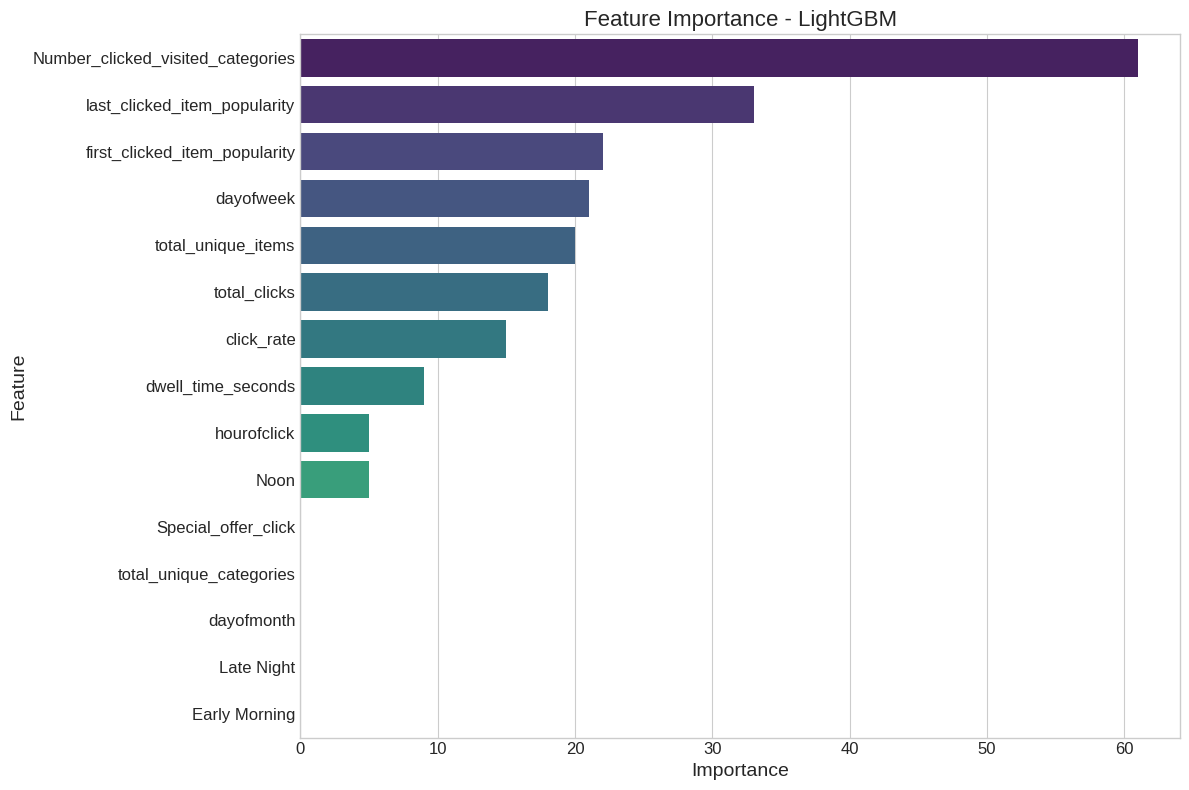

In [5]:
## Model 2: LightGBM

print("\nTraining LightGBM model...")
# Create and train the LightGBM model
gbm = lgb.LGBMClassifier(
    boosting_type="gbdt",
    learning_rate=0.1,
    n_estimators=200,
    num_leaves=32,
    random_state=42,
    n_jobs=-1,
    verbose=50
)

# In newer versions of LightGBM, early_stopping_rounds is passed via callbacks
gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=["auc", "binary_logloss"],
    callbacks=[
        lgb.early_stopping(20)
    ],  # Using callbacks instead of early_stopping_rounds
    
)

# Make predictions
y_pred_proba_gbm = gbm.predict_proba(X_test)[:, 1]
y_pred_gbm = (y_pred_proba_gbm >= 0.5).astype(int)

# Evaluate the model
print("\nLightGBM Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gbm):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_gbm):.4f}")
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_gbm)
print(
    pd.DataFrame(
        cm,
        columns=["Predicted Not Buy", "Predicted Buy"],
        index=["Actual Not Buy", "Actual Buy"],
    )
)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_gbm))

# Plot feature importance
plt.figure(figsize=(12, 8))
# Get feature importances and feature names
feature_imp = pd.DataFrame({
    'Feature': X.columns, 
    'Importance': gbm.feature_importances_
})
# Sort by importance
feature_imp = feature_imp.sort_values('Importance', ascending=False).head(15)
# Create bar plot with seaborn
sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='viridis')
plt.title("Feature Importance - LightGBM", fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()





Training Random Forest model...

Random Forest Results:
Accuracy: 0.5721
AUC: 0.6119

Confusion Matrix:
                Predicted Not Buy  Predicted Buy
Actual Not Buy                 56             51
Actual Buy                     38             63

Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.52      0.56       107
         1.0       0.55      0.62      0.59       101

    accuracy                           0.57       208
   macro avg       0.57      0.57      0.57       208
weighted avg       0.57      0.57      0.57       208



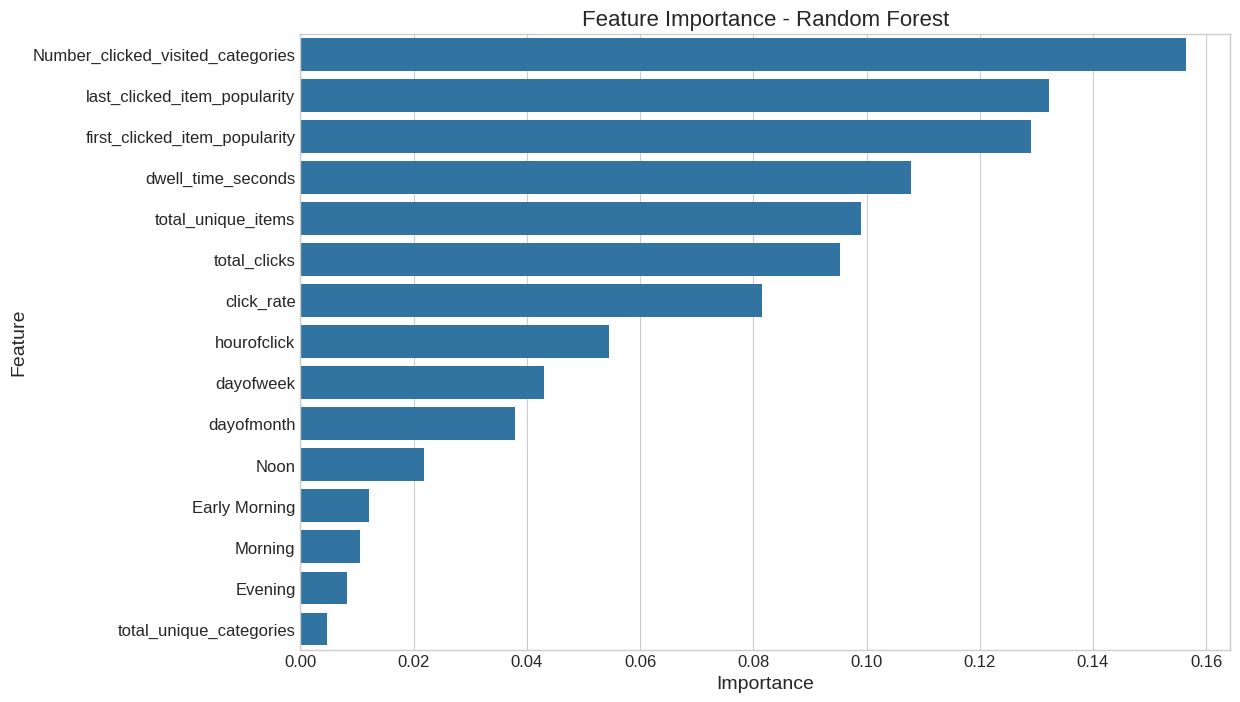


Training Neural Network model with PyTorch...
Starting training...
Epoch [5/50], Train Loss: 0.6829, Train Acc: 0.5865, Val Loss: 0.6899, Val Acc: 0.5721
Epoch [10/50], Train Loss: 0.6686, Train Acc: 0.5986, Val Loss: 0.6833, Val Acc: 0.5625
Epoch [15/50], Train Loss: 0.6447, Train Acc: 0.6214, Val Loss: 0.6824, Val Acc: 0.5769
Epoch [20/50], Train Loss: 0.6371, Train Acc: 0.6154, Val Loss: 0.6849, Val Acc: 0.5865
Epoch [25/50], Train Loss: 0.6328, Train Acc: 0.6250, Val Loss: 0.6855, Val Acc: 0.5962
Early stopping at epoch 26

Neural Network Results:
Accuracy: 0.5962
AUC: 0.6130

Confusion Matrix:
                Predicted Not Buy  Predicted Buy
Actual Not Buy                 80             27
Actual Buy                     57             44

Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.75      0.66       107
         1.0       0.62      0.44      0.51       101

    accuracy                           0.60       208
   m

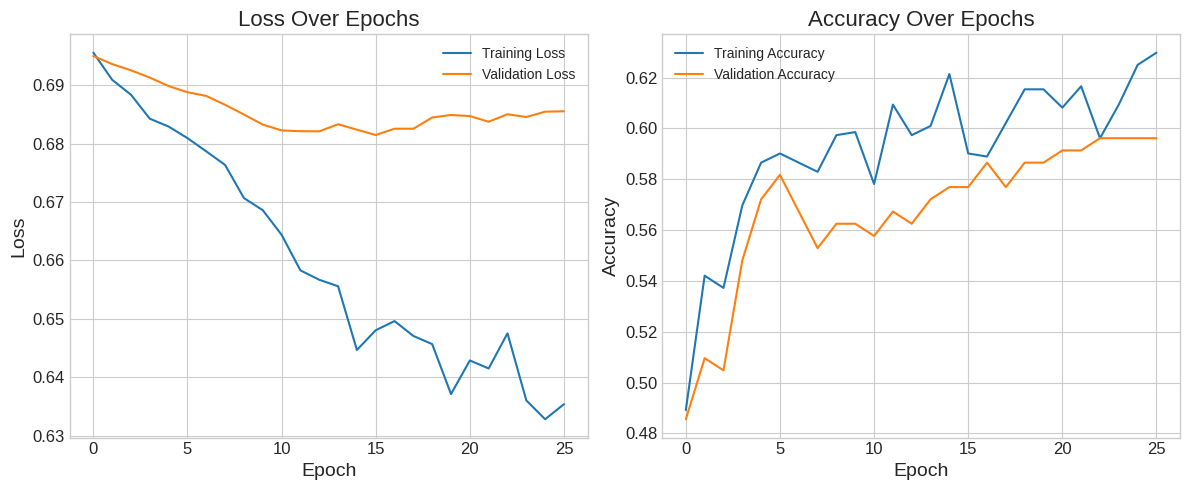


Model Comparison:
                     Accuracy     AUC  Precision  Recall  F1 Score
Model                                                             
Logistic Regression    0.5192  0.5486     0.5038  0.6634    0.5726
LightGBM               0.6058  0.6208     0.5748  0.7228    0.6404
Random Forest          0.5721  0.6119     0.5526  0.6238    0.5860
Neural Network         0.5962  0.6130     0.6197  0.4356    0.5116


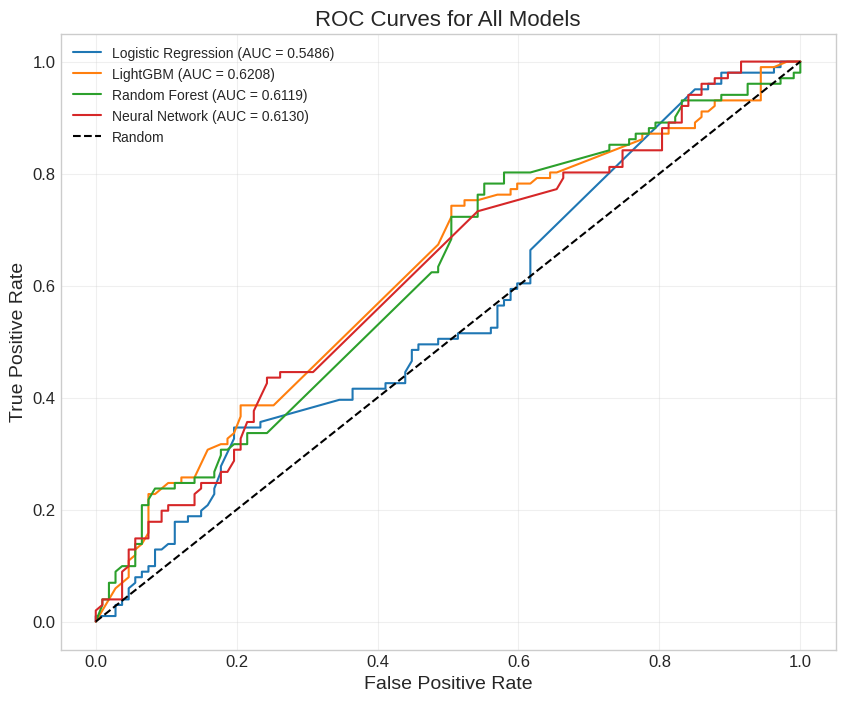

In [4]:
## Model 3: Random Forest

print("\nTraining Random Forest model...")
# Create and train the Random Forest model
rf = RandomForestClassifier(
    n_estimators=100, max_depth=10, min_samples_split=10, random_state=42, n_jobs=-1
)

rf.fit(X_train, y_train)

# Make predictions
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_pred_proba_rf >= 0.5).astype(int)

# Evaluate the model
print("\nRandom Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_rf)
print(
    pd.DataFrame(
        cm,
        columns=["Predicted Not Buy", "Predicted Buy"],
        index=["Actual Not Buy", "Actual Buy"],
    )
)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Plot feature importance
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame(
    {"Feature": X.columns, "Importance": rf.feature_importances_}
).sort_values("Importance", ascending=False)

sns.barplot(x="Importance", y="Feature", data=feature_importance.head(15))
plt.title("Feature Importance - Random Forest")
plt.show()

## Model 4: Neural Network (PyTorch)

print("\nTraining Neural Network model with PyTorch...")


# Define PyTorch model
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(32, 16)
        self.dropout2 = nn.Dropout(0.2)
        self.layer3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout1(x)
        x = self.relu(self.layer2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.layer3(x))
        return x


# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

# Create dataset and dataloader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Initialize model, loss and optimizer
model = BinaryClassifier(input_dim=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = float("inf")
best_model_state = None
patience = 10
patience_counter = 0

# Training loop
print("Starting training...")
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        predicted = (outputs >= 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training metrics
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            predicted = (outputs >= 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation metrics
    val_loss = val_loss / len(test_loader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{epoch+1}/{epochs}], "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}"
        )

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# Make predictions
model.eval()
with torch.no_grad():
    y_pred_proba_nn = model(X_test_tensor).cpu().numpy().flatten()
    y_pred_nn = (y_pred_proba_nn >= 0.5).astype(int)

# Create history dictionary to match TensorFlow format for later plotting
history = {
    "loss": train_losses,
    "val_loss": val_losses,
    "accuracy": train_accuracies,
    "val_accuracy": val_accuracies,
}

# Evaluate the model
print("\nNeural Network Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_nn):.4f}")
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_nn)
print(
    pd.DataFrame(
        cm,
        columns=["Predicted Not Buy", "Predicted Buy"],
        index=["Actual Not Buy", "Actual Buy"],
    )
)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn))

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["accuracy"], label="Training Accuracy")
plt.plot(history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

## Compare Models

print("\nModel Comparison:")
model_comparison = pd.DataFrame(
    {
        "Model": ["Logistic Regression", "LightGBM", "Random Forest", "Neural Network"],
        "Accuracy": [
            accuracy_score(y_test, y_pred_lr),
            accuracy_score(y_test, y_pred_gbm),
            accuracy_score(y_test, y_pred_rf),
            accuracy_score(y_test, y_pred_nn),
        ],
        "AUC": [
            roc_auc_score(y_test, y_pred_proba_lr),
            roc_auc_score(y_test, y_pred_proba_gbm),
            roc_auc_score(y_test, y_pred_proba_rf),
            roc_auc_score(y_test, y_pred_proba_nn),
        ],
        "Precision": [
            precision_score(y_test, y_pred_lr),
            precision_score(y_test, y_pred_gbm),
            precision_score(y_test, y_pred_rf),
            precision_score(y_test, y_pred_nn),
        ],
        "Recall": [
            recall_score(y_test, y_pred_lr),
            recall_score(y_test, y_pred_gbm),
            recall_score(y_test, y_pred_rf),
            recall_score(y_test, y_pred_nn),
        ],
        "F1 Score": [
            f1_score(y_test, y_pred_lr),
            f1_score(y_test, y_pred_gbm),
            f1_score(y_test, y_pred_rf),
            f1_score(y_test, y_pred_nn),
        ],
    }
)

print(model_comparison.set_index("Model").round(4))

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
plt.plot(
    fpr_lr,
    tpr_lr,
    label=f"Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_proba_lr):.4f})",
)

# LightGBM
fpr_gbm, tpr_gbm, _ = roc_curve(y_test, y_pred_proba_gbm)
plt.plot(
    fpr_gbm,
    tpr_gbm,
    label=f"LightGBM (AUC = {roc_auc_score(y_test, y_pred_proba_gbm):.4f})",
)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(
    fpr_rf,
    tpr_rf,
    label=f"Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.4f})",
)

# Neural Network
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_proba_nn)
plt.plot(
    fpr_nn,
    tpr_nn,
    label=f"Neural Network (AUC = {roc_auc_score(y_test, y_pred_proba_nn):.4f})",
)

# Random baseline
plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

